In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import nci
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from models import AffinityModel
from sklearn.model_selection import train_test_split

/Users/jessemurray/Desktop/Main/Rotation1/Code/torchani/torchani/aev.py:18: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")
/Users/jessemurray/Desktop/Main/Rotation1/Code/torchani/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")


In [3]:
df = nci.load_dfs(datasets=('NCIA_HB375x10', 'NCIA_HB300SPXx10'), exclude=True)
df['energies'] = df.energies.astype('float')

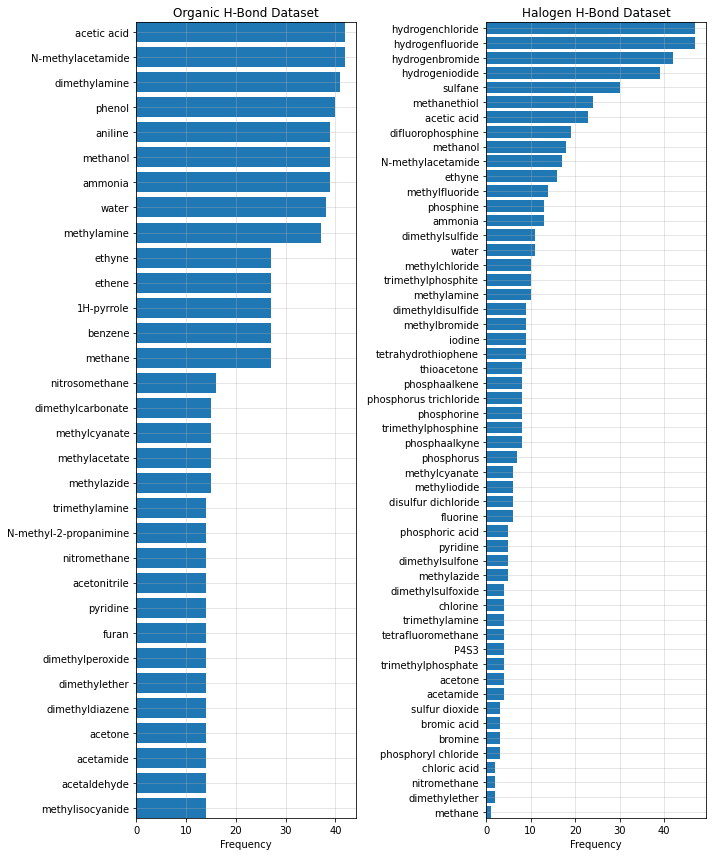

In [52]:
molecule_counts_ = (df.loc[df.dataset == 'NCIA_HB375x10'].MoleculeA.value_counts(ascending=True) / 10).astype('int')
molecule_counts_s = (df.loc[df.dataset == 'NCIA_HB300SPXx10'].MoleculeA.value_counts(ascending=True) / 10).astype('int')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12))
ax1.barh(molecule_counts_.index, molecule_counts_.values)
ax2.barh(molecule_counts_s.index, molecule_counts_s.values)

ax1.margins(y=0)
ax2.margins(y=0)
ax1.set_title('Organic H-Bond Dataset')
ax2.set_title('Halogen H-Bond Dataset')
ax1.set_xlabel('Frequency')
ax2.set_xlabel('Frequency')
ax1.grid(alpha=0.4)
ax2.grid(alpha=0.4)
plt.tight_layout()
plt.savefig('images/n_each_molecule.png', dpi=300)
plt.show()

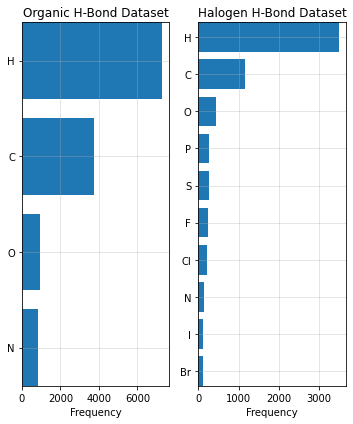

In [51]:
elements = list(set(df.columns).intersection(set(nci.ncia_elements)))
element_counts_ = (df.loc[df.dataset == 'NCIA_HB375x10'][nci.dataset_elements['NCIA_HB375x10']].sum() / 10).astype('int').sort_values(ascending=True)
element_counts_s = (df.loc[df.dataset == 'NCIA_HB300SPXx10'][nci.dataset_elements['NCIA_HB300SPXx10']].sum() / 10).astype('int').sort_values(ascending=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 6))
ax1.barh(element_counts_.index, element_counts_.values)
ax2.barh(element_counts_s.index, element_counts_s.values)
ax1.set_title('Organic H-Bond Dataset')
ax2.set_title('Halogen H-Bond Dataset')
ax1.margins(y=0)
ax2.margins(y=0)
ax1.set_xlabel('Frequency')
ax2.set_xlabel('Frequency')
ax1.grid(alpha=0.4)
ax2.grid(alpha=0.4)
plt.tight_layout()
plt.savefig('images/n_each_element.png', dpi=300)
plt.show()

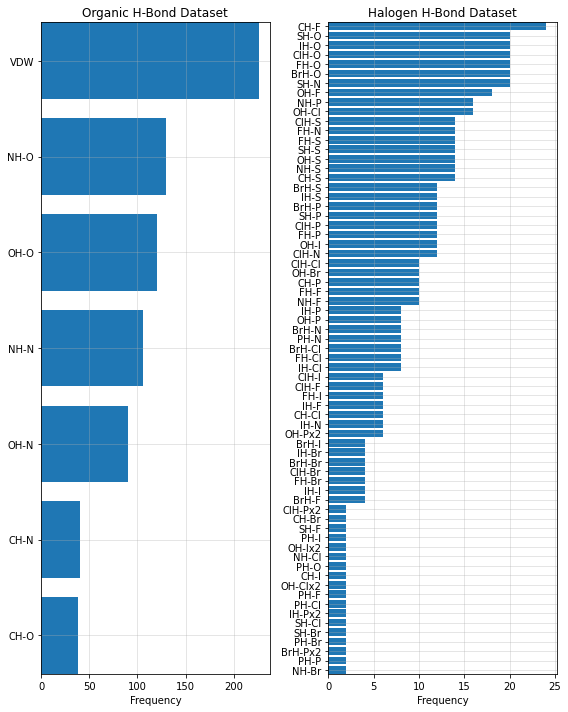

In [53]:
interaction_counts_ = (df.loc[df.dataset == 'NCIA_HB375x10'].interaction.value_counts(ascending=True) / 10).astype('int')
interaction_counts_s = (df.loc[df.dataset == 'NCIA_HB300SPXx10'].interaction.value_counts(ascending=True) / 10).astype('int')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 10))
ax1.barh(interaction_counts_.index, interaction_counts_.values)
ax2.barh(interaction_counts_s.index, interaction_counts_s.values)

ax1.set_title('Organic H-Bond Dataset')
ax2.set_title('Halogen H-Bond Dataset')
ax1.margins(y=0)
ax2.margins(y=0)
ax1.set_xlabel('Frequency')
ax2.set_xlabel('Frequency')
ax1.grid(alpha=0.4)
ax2.grid(alpha=0.4)
plt.tight_layout()
plt.savefig('images/n_each_interaction.png', dpi=300)
plt.show()

In [101]:
df.columns

Index(['MoleculeA', 'MoleculeB', 'interaction_type', 'interaction', 'species',
       'coordinates', 'index_diff', 'energies', 'scaling', 'reverse', 'H',
       'Br', 'I', 'C', 'P', 'N', 'S', 'O', 'Cl', 'F', 'id', 'dataset'],
      dtype='object')

In [12]:
dfe = df.groupby(['interaction_type', 'scaling']).energies
dfe_mean = dfe.mean().reset_index()

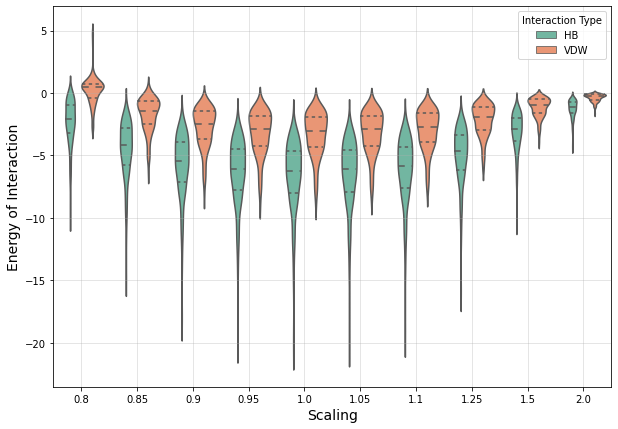

In [13]:
plt.figure(figsize=(10, 7))
sns.violinplot(x='scaling', y='energies', hue='interaction_type', data=df.loc[df.dataset == 'NCIA_HB375x10'],
            inner='quartile', palette='Set2')
plt.grid(alpha=0.4)
fontsize = 12
plt.legend(title='Interaction Type', loc='upper right', fancybox=True)
plt.ylabel('Energy of Interaction', fontsize=fontsize+2)
plt.xlabel('Scaling Factor', fontsize=fontsize+2)
plt.savefig('images/energy_violin.png', dpi=300)
plt.show()

In [14]:
dfe = df.loc[~df.reverse & (df.scaling == 1)].groupby(['MoleculeA', 'MoleculeB']).energies.mean()

In [15]:
dfe.reset_index()

,MoleculeA,MoleculeB,energies
0,1H-pyrrole,N-methyl-2-propanimine,-9.228
1,1H-pyrrole,N-methylacetamide,-9.051
2,1H-pyrrole,acetaldehyde,-6.188
3,1H-pyrrole,acetamide,-9.680
4,1H-pyrrole,acetic acid,-6.696
...,...,...,...
662,water,phosphorus,-1.374
663,water,phosphorus trichloride,-1.922
664,water,pyridine,-7.085
665,water,trimethylamine,-8.010


In [31]:
import matplotlib.cm as cm

def get_df_mig(df):
    df_mi = df.groupby('MoleculeA').interaction.unique().reset_index()
    interaction_dict = {interaction: False for interaction in df.interaction.unique()}
    def make_dict(row):
        out = interaction_dict.copy()
        for group in row.interaction:
            out[group] = True 
        return out
        
    df_mig = pd.DataFrame(df_mi.apply(make_dict, axis=1).tolist()).set_index(df_mi.MoleculeA)
    return df_mig

def plot_df_mig(df_mig, figsize=(15, 15)):
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(df_mig, annot=False, cbar=False, linewidths=0.5, cmap=sns.color_palette("Blues",12), linecolor='black')
    ax.tick_params(left=True, bottom=True, right=True, top=True, labelright=True, labeltop=True)
    # ax.patch.set_edgecolor('black')  
    # ax.patch.set_linewidth('1')  
    plt.xticks(rotation='70')
    plt.yticks(rotation='horizontal')
    plt.ylabel(None)


In [37]:
df_mig_.T

MoleculeA,1H-pyrrole,N-methyl-2-propanimine,N-methylacetamide,acetaldehyde,acetamide,acetic acid,acetone,acetonitrile,ammonia,aniline,...,methylamine,methylazide,methylcyanate,methylisocyanide,nitromethane,nitrosomethane,phenol,pyridine,trimethylamine,water
OH-O,False,False,True,True,True,True,True,False,False,False,...,False,False,True,False,True,True,True,False,False,True
NH-O,True,False,True,True,True,True,True,False,True,True,...,True,False,False,False,True,True,True,False,False,True
OH-N,False,True,False,False,False,True,False,True,True,True,...,True,True,True,False,False,True,True,True,True,True
NH-N,True,True,True,False,False,False,False,True,True,True,...,True,True,True,False,False,False,False,True,True,False
CH-O,False,False,True,True,True,True,True,False,False,False,...,False,False,True,True,True,True,True,False,False,True
CH-N,False,True,False,False,False,False,False,True,True,True,...,True,True,True,True,True,True,False,True,True,False
VDW,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


/var/folders/rd/64lt4yfn7y3ch2mm0wl6g3vw0000gn/T/ipykernel_97286/3998026269.py:3: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


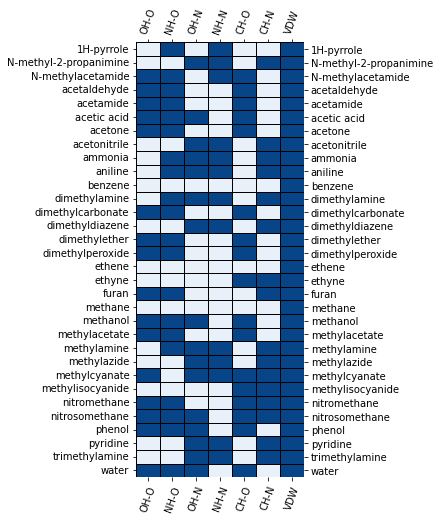

In [47]:
df_mig_ = get_df_mig(df.loc[df.dataset == 'NCIA_HB375x10'])
plot_df_mig(df_mig_, figsize=(3, 8))
plt.tight_layout()
plt.savefig('images/interaction_by_molecule.png', dpi=350, bbox_inches="tight")

In [421]:
df.loc[df.dataset == 'NCIA_HB375x10'].shape

(7500, 22)

In [433]:
df_train_, df_test_ = nci.split_by_molecules(df.loc[df.dataset == 'NCIA_HB375x10'], 
                                        molecules=nci.dataset_exclude['NCIA_HB375x10'])
print(df_train_.shape)
print(df_test_.shape)

(6660, 22)
(840, 22)


In [432]:
df_mig_.loc[nci.dataset_exclude['NCIA_HB375x10']]

,OH-O,NH-O,OH-N,NH-N,CH-O,CH-N,VDW
MoleculeA,,,,,,,
furan,True,True,False,False,False,True,True
acetaldehyde,True,True,False,False,True,False,True
acetonitrile,False,False,True,True,False,True,True


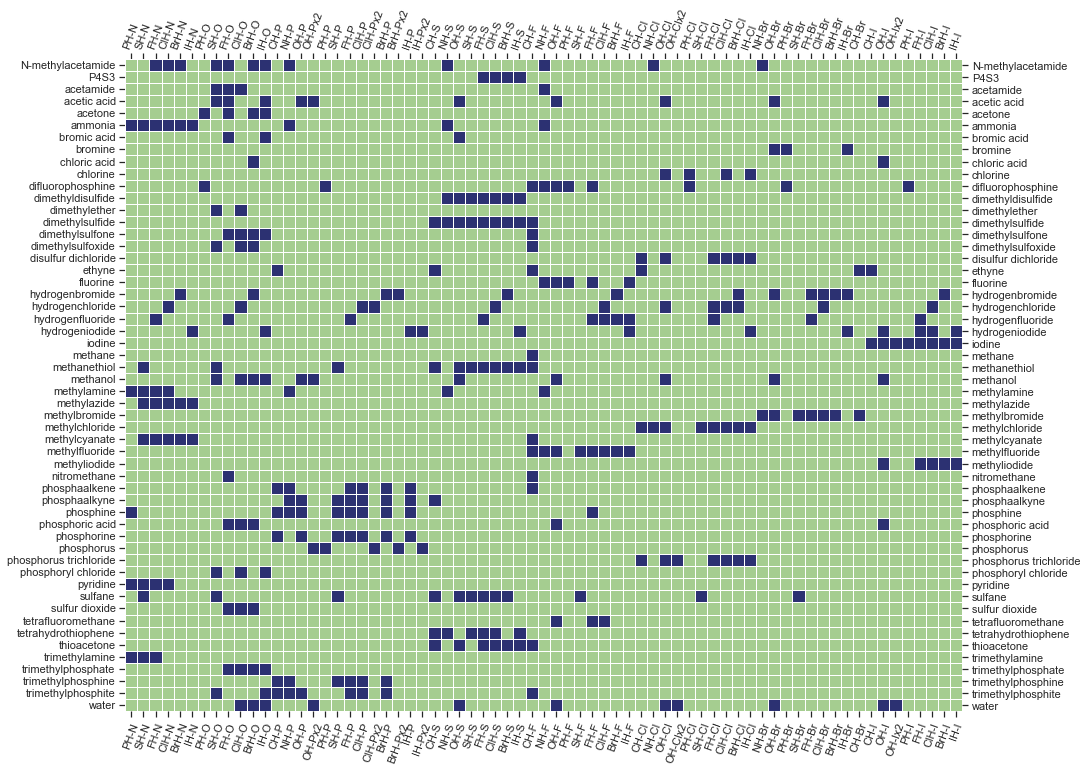

In [398]:
df_mig_s = get_df_mig(df.loc[df.dataset == 'NCIA_HB300SPXx10'])
plot_df_mig(df_mig_s, figsize=(15, 12))

In [436]:

df_train_s, df_test_s = nci.split_by_molecules(df.loc[df.dataset == 'NCIA_HB300SPXx10'], 
                                        molecules=nci.dataset_exclude['NCIA_HB300SPXx10'])
print(df_train_s.shape)
print(df_test_s.shape)

(5620, 22)
(380, 22)


In [437]:
380 / (380 + 5620)

0.06333333333333334

In [441]:
df_mig_s.loc[nci.dataset_exclude['NCIA_HB300SPXx10']].sum()[:20]

PH-N      0
SH-N      0
FH-N      0
ClH-N     0
BrH-N     0
IH-N      0
PH-O      0
SH-O      0
FH-O      1
ClH-O     1
BrH-O     2
IH-O      0
CH-P      1
NH-P      0
OH-P      1
OH-Px2    0
PH-P      0
SH-P      1
FH-P      1
ClH-P     1
dtype: int64

In [442]:
list(set(nci.ncia_elements).intersection(set(df.columns)))

['H', 'Br', 'I', 'C', 'P', 'N', 'S', 'O', 'Cl', 'F']